# Mtcnn Detect Face Step By Step 
Note: This is a straight forward implementation. For faster and more robust implementation, please refer to the source code in mtcnn folder.

### Make sure source root in PYTHONPATH.

In [1]:
import sys
sys.path.append('../')

### First we create networks of three stages (pnet, rnet, onet)

In [2]:
import os
import numpy as np
import mtcnn.network.mtcnn_pytorch as mtcnn

pnet = mtcnn.PNet()
rnet = mtcnn.RNet()
onet = mtcnn.ONet()

weight_folder = '../output/converted'

pnet.load_caffe_model(
    np.load(os.path.join(weight_folder, 'pnet.npy'))[()])
rnet.load_caffe_model(
    np.load(os.path.join(weight_folder, 'rnet.npy'))[()])
onet.load_caffe_model(
    np.load(os.path.join(weight_folder, 'onet.npy'))[()])

### What does these three networks actually do?

We create a fake image and pass them through the three networks. Let's see what happend.

In [3]:
import torch
print("Given ten images with shape (500 * 500).")
pnet_data = torch.randn(10, 3, 500, 500)
ret1, ret2, _ = pnet(pnet_data)
print("Pnet output: \n\tTensor shape of ret1 is %s.\n\tTensor shape of ret2 is %s.\n" % (ret1.shape, ret2.shape))
print("Where does '245' come from?")
print("245 = (500-2)/2-2-2 .\nApply 'minus 2' every Conv layer with kernel 3*3. Apply 'divide 2' every max-pooling layer with kenel 2.")

Given ten images with shape (500 * 500).
Pnet output: 
	Tensor shape of ret1 is torch.Size([10, 2, 245, 245]).
	Tensor shape of ret2 is torch.Size([10, 4, 245, 245]).

Where does '245' come from?
245 = (500-2)/2-2-2 .
Apply 'minus 2' every Conv layer with kernel 3*3. Apply 'divide 2' every max-pooling layer with kenel 2.


In [4]:
rnet_data = torch.randn(10, 3, 24, 24)
print("The input tensor of Rnet must be with shape (24 * 24)")
ret1, ret2, _ = rnet(rnet_data)
print("Rnet output: \n\tTensor shape of ret1 is %s.\n\tTensor shape of ret2 is %s.\n" % (ret1.shape, ret2.shape))

The input tensor of Rnet must be with shape (24 * 24)
Rnet output: 
	Tensor shape of ret1 is torch.Size([10, 2]).
	Tensor shape of ret2 is torch.Size([10, 4]).



In [5]:
onet_data = torch.randn(10, 3, 48, 48)
print("The input tensor of Rnet must be with shape (48 * 48)")
ret1, ret2, ret3 = onet(onet_data)
print("Rnet output: \n\tTensor shape of ret1 is %s.\n\tTensor shape of ret2 is %s.\n\tTensor shape of ret3 is %s." % (ret1.shape, ret2.shape, ret3.shape))

The input tensor of Rnet must be with shape (48 * 48)
Rnet output: 
	Tensor shape of ret1 is torch.Size([10, 2]).
	Tensor shape of ret2 is torch.Size([10, 4]).
	Tensor shape of ret3 is torch.Size([10, 10]).


### Let's getting start with a real image.

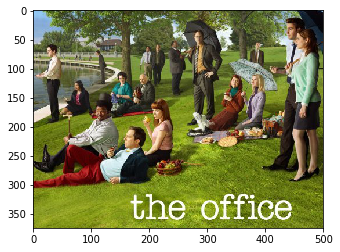

In [6]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

img = Image.open('../tests/asset/images/office5.jpg')
img_array = np.asarray(img)
plt.imshow(img_array)
plt.show()

### First, we create image pyramid.

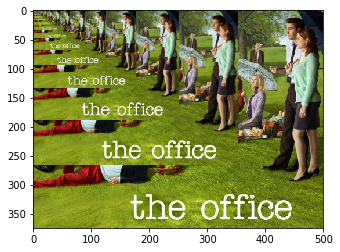

In [7]:
import math

minsize = 12
factor = 0.707

width = img.size[0]
height = img.size[1]

# Compute valid scales
scales = []
cur_width = width
cur_height = height
cur_factor = 1
while cur_width >= minsize and cur_height >= minsize:
    # ensure width and height are even
    w = cur_width
    h = cur_height
    scales.append((w, h, cur_factor))

    cur_factor *= factor
    cur_width = math.ceil(cur_width * factor)
    cur_height = math.ceil(cur_height * factor)
    
# Resize the image
img_pyramid = img_array.copy()
pyramid_list = []
for w, h, f in scales:
    im = img.resize((w, h), Image.BILINEAR)
    im = np.asarray(im)
    img_pyramid[0:h, 0:w] = im
    pyramid_list.append(im)
    
plt.imshow(img_pyramid)
plt.show()  

### For each resized image in pyramid, pass it into pnet and get classification feature map and bounding box regression feature map.

In [8]:
def preprocess(img):
    """
    Convert image from NDArray to torch.FloatTensor. 
    """
    img = img.transpose(2, 0, 1)
    img = torch.FloatTensor(img)
    # The input of pnet must be normalized.
    img = (img - 127.5) * 0.0078125
    img = torch.unsqueeze(img, 0)
    return img
    
for (w, h, f), im in zip(scales, pyramid_list):
    im = preprocess(im)
    p_distribution, box_regs, _ = pnet(im)
    score = p_distribution[:, 1]
    
    print("Input shape: %s.\n\t-->Score shape %s.\n\t-->Box regression shpae %s.\n" % (im.shape, score.shape, box_regs.shape))

Input shape: torch.Size([1, 3, 375, 500]).
	-->Score shape torch.Size([1, 183, 245]).
	-->Box regression shpae torch.Size([1, 4, 183, 245]).

Input shape: torch.Size([1, 3, 266, 354]).
	-->Score shape torch.Size([1, 128, 172]).
	-->Box regression shpae torch.Size([1, 4, 128, 172]).

Input shape: torch.Size([1, 3, 189, 251]).
	-->Score shape torch.Size([1, 90, 121]).
	-->Box regression shpae torch.Size([1, 4, 90, 121]).

Input shape: torch.Size([1, 3, 134, 178]).
	-->Score shape torch.Size([1, 62, 84]).
	-->Box regression shpae torch.Size([1, 4, 62, 84]).

Input shape: torch.Size([1, 3, 95, 126]).
	-->Score shape torch.Size([1, 43, 58]).
	-->Box regression shpae torch.Size([1, 4, 43, 58]).

Input shape: torch.Size([1, 3, 68, 90]).
	-->Score shape torch.Size([1, 29, 40]).
	-->Box regression shpae torch.Size([1, 4, 29, 40]).

Input shape: torch.Size([1, 3, 49, 64]).
	-->Score shape torch.Size([1, 20, 27]).
	-->Box regression shpae torch.Size([1, 4, 20, 27]).

Input shape: torch.Size([1, 3

### So how can we map output feature to the location of original image. Let's take the fifth image as exmple.

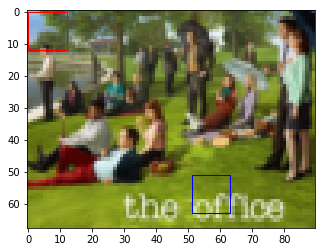

We caculate Correspondence by this fomula: 
	x1 = x1_map * 2 + 1, 
	y1 = y1_map * 2 + 1, 
	x2 = x1_map * 2 + 1 + 12, 
	y2 = y2_map * 2 + 1 + 12.
So the axis of Red box in original image is (1, 1, 13, 13), which Correspond to (0, 0) in feature map.
The axis of blue box in original image is (51, 51, 63, 63), which correspond to (25, 25) in feature map.mro


In [9]:
import matplotlib.patches as patches
w, h, f = scales[5]
im = pyramid_list[5].copy()

# Create figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(im)

# Create a Rectangle patch
rect = patches.Rectangle((0,0),12,12,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

# Create a Rectangle patch
rect = patches.Rectangle((51,51),12,12,linewidth=1,edgecolor='b',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

plt.imshow(im)
plt.show()

print("We caculate Correspondence by this fomula: \n\tx1 = x1_map * 2 + 1, \n\ty1 = y1_map * 2 + 1, \n\tx2 = x1_map * 2 + 1 + 12, \n\ty2 = y2_map * 2 + 1 + 12.")
print("So the axis of Red box in original image is (1, 1, 13, 13), which Correspond to (0, 0) in feature map.")
print("The axis of blue box in original image is (51, 51, 63, 63), which correspond to (25, 25) in feature map.mro")


### So let's caculate the corresponding boxes of all boxes with high score.

In [10]:
def generate_bboxes(probs, offsets, scale, threshold):
        """Generate bounding boxes at places
        where there is probably a face.

        Arguments:
            probs: a FloatTensor of shape [1, 2, n, m].
            offsets: a FloatTensor array of shape [1, 4, n, m].
            scale: a float number,
                width and height of the image were scaled by this number.
            threshold: a float number.

        Returns:
            boxes: LongTensor with shape [x, 4].
            score: FloatTensor with shape [x].
        """

        # applying P-Net is equivalent, in some sense, to
        # moving 12x12 window with stride 2
        stride = 2
        cell_size = 12

        # extract positive probability and resize it as [n, m] dim tensor.
        probs = probs[0, 1, :, :]

        # indices of boxes where there is probably a face
        inds = (probs > threshold).nonzero()

        if inds.shape[0] == 0:
            return torch.empty((0, 4), dtype=torch.int32), torch.empty(0, dtype=torch.float32), torch.empty((0, 4), dtype=torch.float32)

        # transformations of bounding boxes
        tx1, ty1, tx2, ty2 = [offsets[0, i, inds[:, 0], inds[:, 1]]
                              for i in range(4)]
        # they are defined as:
        # w = x2 - x1 + 1
        # h = y2 - y1 + 1
        # x1_true = x1 + tx1*w
        # x2_true = x2 + tx2*w
        # y1_true = y1 + ty1*h
        # y2_true = y2 + ty2*h

        offsets = torch.stack([tx1, ty1, tx2, ty2], 1)
        score = probs[inds[:, 0], inds[:, 1]]

        # P-Net is applied to scaled images
        # so we need to rescale bounding boxes back
        bounding_boxes = torch.stack([
            stride*inds[:, 1] + 1.0,
            stride*inds[:, 0] + 1.0,
            stride*inds[:, 1] + 1.0 + cell_size,
            (stride*inds[:, 0] + 1.0 + cell_size),
        ], 0).transpose(0, 1).float()

        bounding_boxes = torch.round(bounding_boxes / scale).int()
        return bounding_boxes, score, offsets
    
candidate_boxes = torch.empty((0, 4), dtype=torch.int32)
candidate_scores = torch.empty((0))
candidate_offsets = torch.empty((0, 4), dtype=torch.float32)
    
for (w, h, f), im in zip(scales, pyramid_list):
    im = preprocess(im)
    p_distribution, box_regs, _ = pnet(im)
    
    # we set filter threshold 0.6 here
    candidate, scores, offsets = generate_bboxes(p_distribution, box_regs, f, 0.6)
    candidate_boxes = torch.cat([candidate_boxes, candidate])
    candidate_scores = torch.cat([candidate_scores, scores])
    candidate_offsets = torch.cat([candidate_offsets, offsets])

### Let's see what these boxes looks like here.

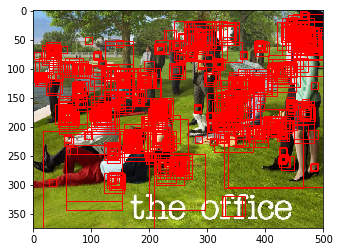

It seems that there are many boxes around regions with face. Pretty good!
There are olso many redundant box here and the axis is olso inaccurate. Don't worry about it.


In [11]:
img_origin = img_array.copy()

def show_boxes(img, boxes):
    
    # Create figure and axes
    fig, ax = plt.subplots(1)

    # Display the image
    ax.imshow(img)
    for box in boxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()
    
show_boxes(img_origin, candidate_boxes)
print("It seems that there are many boxes around regions with face. Pretty good!")
print("There are olso many redundant box here and the axis is olso inaccurate. Don't worry about it.")

### We have another three things to do in the first stage detection. Accurately adjust coordinates，nms and re-convert boxes to square.

In [12]:
def calibrate_box(bboxes, offsets):
    """Transform bounding boxes to be more like true bounding boxes.
    'offsets' is one of the outputs of the nets.

    Arguments:
        bboxes: a IntTensor of shape [n, 4].
        offsets: a IntTensor of shape [n, 4].

    Returns:
        a IntTensor of shape [n, 4].
    """
    x1, y1, x2, y2 = [bboxes[:, i] for i in range(4)]
    w = x2 - x1 + 1.0
    h = y2 - y1 + 1.0
    w = torch.unsqueeze(w, 1)
    h = torch.unsqueeze(h, 1)

    translation = torch.cat([w, h, w, h], 1).float() * offsets
    bboxes += torch.round(translation).int()
    return bboxes

def convert_to_square(bboxes):
    """Convert bounding boxes to a square form.

    Arguments:
        bboxes: a IntTensor of shape [n, 4].

    Returns:
        a IntTensor of shape [n, 4],
            squared bounding boxes.
    """

    square_bboxes = torch.zeros_like(bboxes, dtype=torch.float32)
    x1, y1, x2, y2 = [bboxes[:, i].float() for i in range(4)]
    h = y2 - y1 + 1.0
    w = x2 - x1 + 1.0
    max_side = torch.max(h, w)
    square_bboxes[:, 0] = x1 + w*0.5 - max_side*0.5
    square_bboxes[:, 1] = y1 + h*0.5 - max_side*0.5
    square_bboxes[:, 2] = square_bboxes[:, 0] + max_side - 1.0
    square_bboxes[:, 3] = square_bboxes[:, 1] + max_side - 1.0

    square_bboxes = torch.ceil(square_bboxes + 1).int()
    return square_bboxes

def refine_boxes(bboxes, w, h):
    """
    Avoid coordinates beyond image size
    """

    bboxes = torch.max(torch.zeros_like(bboxes), bboxes)
    sizes = torch.IntTensor([[w, h, w, h]] * bboxes.shape[0])
    bboxes = torch.min(bboxes, sizes)
    return bboxes

def nms(dets, scores, thresh, mode="Union"):
    """
    greedily select boxes with high confidence
    keep boxes overlap <= thresh
    rule out overlap > thresh
    :param dets: [[x1, y1, x2, y2 score]]
    :param thresh: retain overlap <= thresh
    :return: indexes to keep
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = scores

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        if mode == "Union":
            ovr = inter / (areas[i] + areas[order[1:]] - inter)
        elif mode == "Minimum":
            ovr = inter / np.minimum(areas[i], areas[order[1:]])

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return np.array(keep)


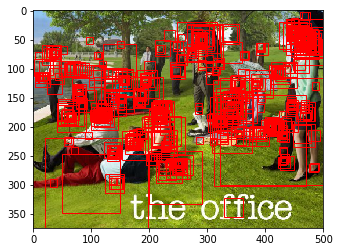

In [13]:
candidate_boxes = calibrate_box(candidate_boxes, candidate_offsets)
candidate_boxes = convert_to_square(candidate_boxes)
candidate_boxes = refine_boxes(candidate_boxes, width, height)
keep = nms(candidate_boxes.cpu().detach().numpy(), candidate_scores.cpu().detach().numpy(), 0.7)
candidate_boxes = candidate_boxes[keep]
show_boxes(img_array.copy(), candidate_boxes)

### Here we finish the stage one and generate many candidate boxes. Let's start stage two.
**Stage 2 is much easier than stage one. We just resize candidate boxes to (24, 24), filter boxes by score and accurately adjust coordinates，nms and re-convert boxes to square like stage one.**


In [14]:
boxes = candidate_boxes
# Step one: crop and resize the images and pre-process them.
stage_two_imgs = []
for box in boxes:
    im = img_array[box[1]: box[3], box[0]: box[2]]
    im = Image.fromarray(im)
    im = im.resize((24, 24), Image.BILINEAR)
    im = np.asarray(im)
    im = preprocess(im)
    stage_two_imgs.append(im)
    
stage_two_imgs = torch.cat(stage_two_imgs)

# Step two: filter the boxes by scores given by rnet
p_distribution, box_regs, _ = rnet(stage_two_imgs)  # rnet forward pass
scores = p_distribution[:, 1]
mask = (scores >= 0.7)
boxes = boxes[mask]
box_regs = box_regs[mask]
scores = scores[mask]

boxes = calibrate_box(boxes, box_regs)
boxes = convert_to_square(boxes)
boxes = refine_boxes(boxes, width, height)

# nms
keep = nms(boxes.cpu().detach().numpy(), scores.cpu().detach().numpy(), 0.7)
boxes = boxes[keep]

### Let's see the result

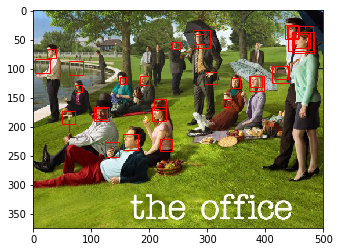

In [15]:
show_boxes(img_array.copy(), boxes)

### Stage three is almost same with stage 2. Except that there is no "convert_to_square" operation.

In [16]:
# Step one: crop and resize the images and pre-process them.
stage_three_imgs = []
for box in boxes:
    im = img_array[box[1]: box[3], box[0]: box[2]]
    im = Image.fromarray(im)
    im = im.resize((48, 48), Image.BILINEAR)
    im = np.asarray(im)
    im = preprocess(im)
    stage_three_imgs.append(im)
    
stage_two_imgs = torch.cat(stage_three_imgs)

# Step two: filter the boxes by scores given by rnet
p_distribution, box_regs, _ = onet(stage_two_imgs)  # rnet forward pass
scores = p_distribution[:, 1]
mask = (scores >= 0.6)
boxes = boxes[mask]
box_regs = box_regs[mask]
scores = scores[mask]

boxes = calibrate_box(boxes, box_regs)
boxes = refine_boxes(boxes, width, height)

# nms
keep = nms(boxes.cpu().detach().numpy(), scores.cpu().detach().numpy(), 0.3)
boxes = boxes[keep]

### Let's see the final result

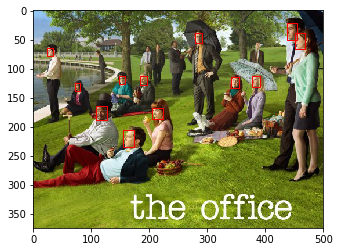

In [17]:
show_boxes(img_array.copy(), boxes)

### Pretty good. Isn't it?